## Custom Agent Masks for subsampling the dataset

Reference: https://www.kaggle.com/fnands/makesubmasks

 - Full training set is huge.
 - For prototyping the models its better to subsample the dataset to create a smaller dataset.
 - In full training dataset, frame to frame there is not much difference in a scene. if you look at framen `n` and frame `n+1` in a scene, it will look more or less identical. This much fine grained details might be required for the final model. But in order to do faster prototyping, we can go with much more coarse grained dataset.
 - But for initial prototyping, we can subsample by skipping some consecutive frames, where will have more prominant difference frame-to-frame.


 - Also matching testset.
    - In the testset, we are asked to predict the future of the frame # 100. that is 50 future predictions.
    - So we can subsample agents with atleast 100 history frames, and 50 future frames.
    

In [1]:
import sys
from pathlib import Path

l5kit_repo = Path("../../l5kit/l5kit").resolve()
l5kit_repo

PosixPath('/home/nisarkavungal_gmx_com/l5kit/l5kit')

In [2]:
sys.path.insert(0, str(l5kit_repo)) # override the installed l5kit package

### Imports

In [3]:
import numpy as np
import pandas as pd

from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset
from l5kit.rasterization import build_rasterizer
from l5kit.data.filter import get_agents_slice_from_frames

Importing from l5kit fork


### Load the zarr data

In [4]:
os.environ["L5KIT_DATA_FOLDER"] = "/home/nisarkavungal_gmx_com/lyft-data"

In [5]:
dm = LocalDataManager()

ds_path = dm.require("scenes/train.zarr")
ds_path

'/home/nisarkavungal_gmx_com/lyft-data/scenes/train.zarr'

In [6]:
chunked_ds = ChunkedDataset(ds_path)
chunked_ds.open()

In [7]:
print(chunked_ds)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   16265    |  4039527   | 320124624  |    38735988   |      112.19     |        248.36        |        79.25         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


### Basic Mask

For selecting agents between a `start_frame` and `end_frame` at an `interval`.  

This can be used to select agents in a scene with frame slice [100:200:10] for example. This matches the test data

In [8]:
n_agents = len(chunked_ds.agents)
frame_mask = np.zeros((n_agents,))

In [9]:
interval = 10
start_frame = 100
end_frame = 200

In [10]:
%%time
for scene in chunked_ds.scenes:
    f1, _ = scene["frame_index_interval"]
    for frame_no in np.arange(f1 + start_frame, f1 + end_frame, interval): # start from 100, end at 200, every 10th frame
        agent_slice = get_agents_slice_from_frames(chunked_ds.frames[frame_no]) # agent array slice for the frame.
        frame_mask[agent_slice] = 1

CPU times: user 3min 10s, sys: 4min 31s, total: 7min 42s
Wall time: 2min 43s


In [14]:
print(f"# of filtered agenst: {np.sum(frame_mask):,}")
print(f"Total # of agents: {frame_mask.shape[0]:,}")

# of filtered agenst: 12,915,885.0
Total # of agents: 320,124,624


We will be merging this mask with the default mask l5kit (which returns agents that meet certain conditions) produces

### Agent Dataset

In [15]:
from l5kit.configs import load_config_data
from pprint import pprint

cfg = load_config_data("l5kit_vis.yaml")
pprint(cfg)

{'format_version': 4,
 'model_params': {'future_delta_time': 0.1,
                  'future_num_frames': 50,
                  'future_step_size': 1,
                  'history_delta_time': 0.1,
                  'history_num_frames': 50,
                  'history_step_size': 1,
                  'model_architecture': 'resnet50'},
 'raster_params': {'dataset_meta_key': 'meta.json',
                   'ego_center': [0.25, 0.5],
                   'filter_agents_threshold': 0.5,
                   'map_type': 'py_semantic',
                   'pixel_size': [0.5, 0.5],
                   'raster_size': [224, 224],
                   'satellite_map_key': 'aerial_map/aerial_map.png',
                   'semantic_map_key': 'semantic_map/semantic_map.pb'},
 'val_data_loader': {'batch_size': 12,
                     'key': 'scenes/sample.zarr',
                     'num_workers': 16,
                     'shuffle': False}}


In [16]:
cfg["raster_params"]["map_type"] = "py_satellite"
rasterizer = build_rasterizer(cfg, dm)
train_ds_full = AgentDataset(cfg, chunked_ds, rasterizer)

In [17]:
len(train_ds_full)

22496709

In [18]:
train_ds_full[0]["image"].shape

(105, 224, 224)

Load the default mask that is used for agent dataset.  

This is the full agent mask which enables agents that meets the minimum requirements in l5kit.  

That is pass the `filter_agent_method` function and with enough past (default 1) and future (future 10) frames. 

In [19]:
full_mask = train_ds_full.load_agents_mask()
full_mask

array([[0, 0],
       [0, 0],
       [0, 0],
       ...,
       [0, 0],
       [0, 0],
       [0, 0]], dtype=uint32)

In [20]:
print(f"Total agents in full mask: {np.sum(full_mask[:, 0]):,}")

Total agents in full mask: 1,394,557,362


Transform the mask to 1D

In [21]:
# set 1 for full mask 0th element = 1
full_mask_1d = np.where(full_mask[:, 0] > 0, np.ones_like(full_mask[:, 0]), np.zeros_like(full_mask[:, 0]))

Combine the framemask and full_mask_1d

In [22]:
mask = frame_mask * full_mask_1d

In [30]:
print(f"agent dataset length before filtering: {len(train_ds_full):,}")
print(f"Filtered agent dataset length: {np.sum(mask):,}")

agent dataset length before filtering: 22,496,709
Filtered agent dataset length: 1,988,801.0
48871015


Store the mask

In [31]:
outfile = f"mask_{start_frame}_{end_frame}_{interval}"
np.savez(outfile, mask.astype(bool))

### Test the mask created

In [32]:
readmask = np.load(outfile + ".npz")

In [33]:
mask = readmask["arr_0"]

In [34]:
print(f"Total enabled agents: {np.sum(mask)}")

Total enabled agents: 1988801


In [35]:
train_ds = AgentDataset(cfg, chunked_ds, rasterizer, agents_mask=mask)

In [36]:
len(train_ds)

1988801

Matches the mask

In [38]:
train_ds[1]["image"].shape

(105, 224, 224)

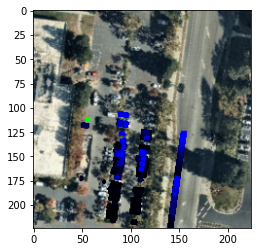

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt

def get_image(ds):
    return ds.rasterizer.to_rgb(train_ds[50]["image"].transpose(1, 2, 0))
plt.imshow(get_image(train_ds))

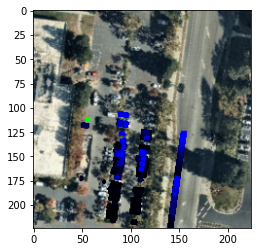

In [44]:
plt.imshow(get_image(train_ds_full))